# Augumentation Techqnique For Making realistic data at higher nTTs

In [3]:
import matplotlib.pyplot as plt
import mplhep as hep
import uproot as urt
import ROOT
import json,sys,os
import numpy as np

Welcome to JupyROOT 6.26/10


## Idea

Make an augumented dataset with flat distribution in nTT . This will allow derivation of Isolation thersholds for higher nTT bins

- Steps
  - Define `base dataset` [`BD`] as all the events in the re emulated sample with `l1tEmuRawEt > 0`
  - Bin `BD` in nTT bins [ 20 to 200 in bins of width 20 ]  // kind of arbirary choise as of now
  - For each bin 
      - take the data that is already there in `BD` as `existingData` 
      - Deriven number of events to be drawn to attain the global flat distribution in nTT : 
      - Define the dataset `dataToSampleFrom` from  as events in `BD` after removing `existingData`
      - Identify the PDF in NTT that need to be drawn so that the final distribution is flat
      - Draw `nTT` for the augumented dataset from this distribution : `augmented_nTTVals`
      - Draw `nEventsToSample` from `dataToSampleFrom`
      - Derive  IsoEt of the `augmented_dataSet` as 
          - `augmented_dataSet[ISO ET] =  augmented_dataSet[ISO ET] + slope * ( augmented_dataSet[NTT] -augmented_nTTVals )`
      - Set `augmented_dataSet[ISO ET] = augmented_nTTVals`
   - Good to go

#### Branches required by step 1 and step 2

In [4]:
branchList=["l1tEmuNTT",
            "l1tEmuRawEt",
            "l1tEmuTowerIEta",
            "l1tEmuIsoEt",
            "eleProbeEta"  ,
            "eleProbePhi"  ,
            "eleTagEta"    ,
            "eleTagPhi"    ,
            "isProbeLoose" ]

In [5]:
prefixBase= 'workarea/results/dataAug/'
os.system('mkdir -p '+prefixBase)

0

#### Open the base datafile here ]

- We use the EraG files

In [12]:
tAndPTree=urt.open('workarea/TagAndProbe_ReEmul_EGEraG_Remul_caloParam_v0_6_recalib_v0p2.root:Ntuplizer/TagAndProbe')

#### Reading the branches and defining the safety mask to ignore bad events 

In [14]:
baseSet=tAndPTree.arrays(branchList, library="np")

safetyMask= baseSet['l1tEmuRawEt'] > 0.0

baseSet={ ky : baseSet[ky][safetyMask]  for ky in baseSet }
print("Nuber total events : ",baseSet['l1tEmuRawEt'].shape[0])

Nuber total events :  390117


#### Checking basic histograms

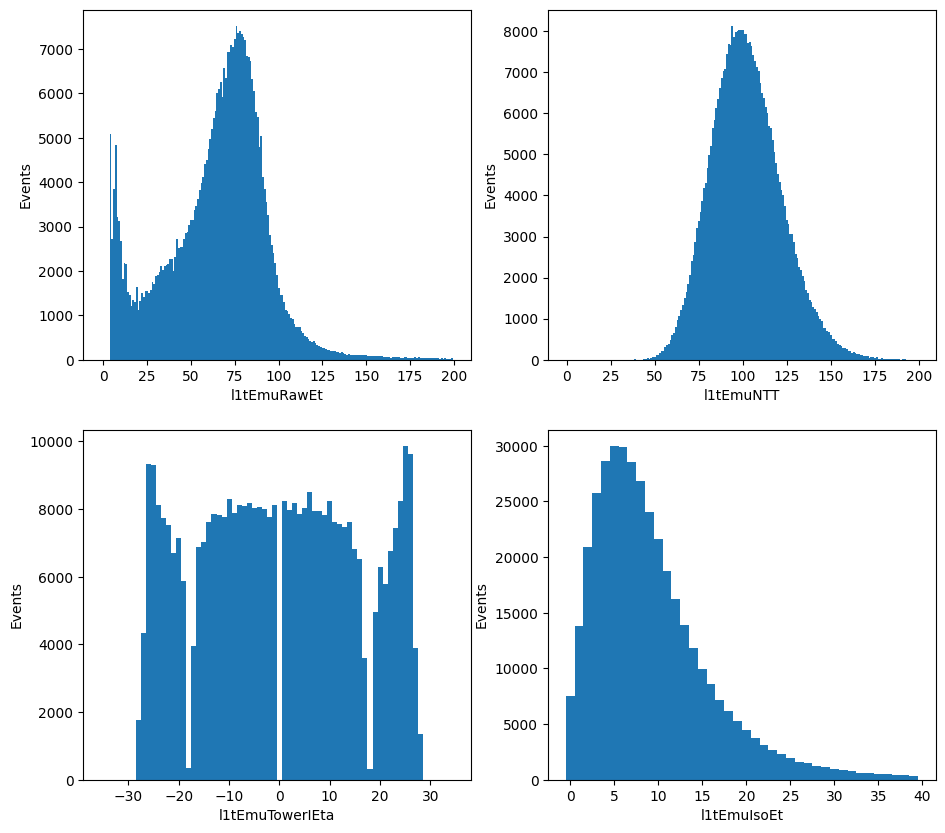

In [15]:
f,ax=plt.subplots(2,2,figsize=(11,10))
ax=np.ndarray.flatten(ax)
_=ax[0].hist(baseSet['l1tEmuRawEt'],bins=np.arange(-1.5,200.5,1))
ax[0].set_xlabel('l1tEmuRawEt')  ; ax[0].set_ylabel('Events')
_=ax[1].hist(baseSet['l1tEmuNTT']  ,bins=np.arange(-0.5,200.5,1))
ax[1].set_xlabel('l1tEmuNTT')  ; ax[1].set_ylabel('Events')
_=ax[2].hist(baseSet['l1tEmuTowerIEta'],bins=np.arange(-35.5,35.5,1))
ax[2].set_xlabel('l1tEmuTowerIEta')  ; ax[2].set_ylabel('Events')
_=ax[3].hist(baseSet['l1tEmuIsoEt']  ,bins=np.arange(-0.5,40.5,1))
ax[3].set_xlabel('l1tEmuIsoEt')  ; ax[3].set_ylabel('Events')
f.savefig(prefixBase+'/default_l1Histograms.png',bbox_inches='tight')

#### Bin edges for the nTT binnig

In [17]:
binEdges=np.arange(-0.5,199.5,1)
counts,edg=np.histogram(baseSet['l1tEmuNTT'],bins=binEdges)
nTargetPerNTT=max(counts)

binSize=20
binEdges=np.arange(39.5,199.5,binSize)
counts,edg=np.histogram(baseSet['l1tEmuNTT'],bins=binEdges)
nTargetPerBin=nTargetPerNTT*binSize
print("Bin Edges  : ",binEdges)
print("Counts per bin : ",counts)
print("events to have per bin : ",nTargetPerBin)

Bin Edges  :  [ 39.5  59.5  79.5  99.5 119.5 139.5 159.5 179.5]
Counts per bin :  [  2663  44068 137283 134184  56064  13576   2072]
events to have per bin :  162380


In [18]:
nTTMin=binEdges[1]
nTTMax=binEdges[2]
print("Making dataset for nTT bin [  ",nTTMin,nTTMax," ]")

Making dataset for nTT bin [   59.5 79.5  ]


#### Making the `dataToSampleFrom` and `existingData`

In [19]:
baseMaskInBin =np.logical_and( baseSet['l1tEmuNTT'] < nTTMax , baseSet['l1tEmuNTT'] >= nTTMin ) 
existingData={ ky : baseSet[ky][baseMaskInBin] for ky in baseSet } 

baseMaskNotInBin = np.logical_not(baseMaskInBin)
dataToSampleFrom={ky : baseSet[ky][baseMaskNotInBin] for ky in baseSet}

nEventsToSample = nTargetPerBin - np.sum(baseMaskInBin)
nEventsInBaseToSampleFrom= np.sum(baseMaskNotInBin)
print("Number of events in  existingData : ",np.sum(baseMaskInBin))
print("Number of events to be sampled : ",nEventsToSample)
print("Number of events in dataToSampleFrom from   : ",nEventsInBaseToSampleFrom)

Number of events in  existingData :  44068
Number of events to be sampled :  118312
Number of events in dataToSampleFrom from   :  346049


#### Deriving the PDF of nTT distribution to sample from

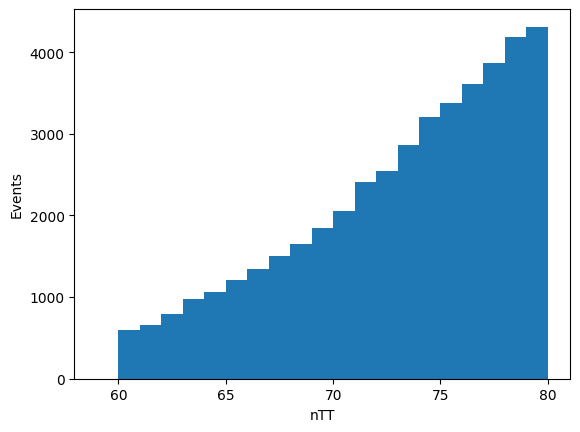

In [20]:
nEvts,nTTs,_=plt.hist(existingData['l1tEmuNTT'],bins=np.arange(nTTMin-0.5,nTTMax+1,1))
nTTs=0.5*(nTTs[:-1]+nTTs[1:])  
plt.xlabel('nTT')
plt.ylabel('Events')
plt.show()
plt.savefig(prefixBase+'/nTTinBin.png',bbox_inches='tight')
plt.close()

In [21]:
nEventsToSamplePerBin=int(nTargetPerBin/nEvts.shape[0])
eventCountToSample = np.ones(nEvts.shape[0],int)*int(nEventsToSamplePerBin)-nEvts # number of events to be sampled removing the existing events

eventCountToSample[eventCountToSample < 0 ]=0  # don't sample events with nTT where we already have statistics
eventCountToSample=(eventCountToSample)

probaPerBin=eventCountToSample/np.sum(eventCountToSample)
print(probaPerBin,np.sum(probaPerBin))

[0.06535705 0.06028537 0.05976975 0.05863707 0.05712402 0.05638863
 0.05517988 0.05399648 0.05263558 0.05142683 0.04977854 0.04796118
 0.04501961 0.04387003 0.04110596 0.03826582 0.03680349 0.03484244
 0.03268698 0.02995672 0.02890857] 0.9999999999999999


#### Drawing `nTT` from the derived distribution

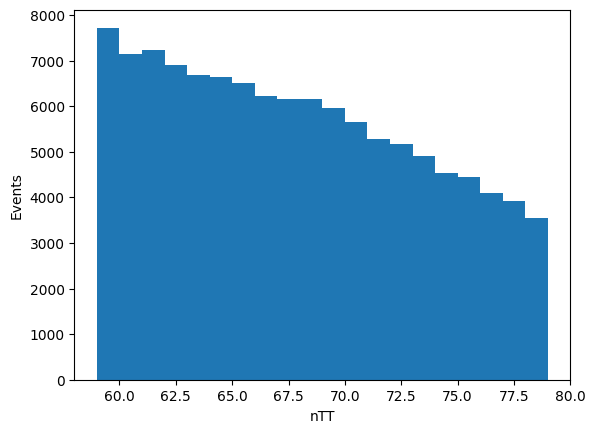

In [22]:
augmented_nTTVals =  np.random.choice(nTTs,nEventsToSample,p=probaPerBin)

_=plt.hist(augmented_nTTVals,bins=np.arange(nTTMin-0.5,nTTMax+0.5,1))
plt.xlabel('nTT')
plt.ylabel('Events')
plt.show()
# plt.savefig(prefixBase+'/ntt_augumented.png',bbox_inches='tight')

#### Drawing the events from the sample distribution

In [23]:
sample_idx=np.random.choice(nEventsInBaseToSampleFrom ,size=nEventsToSample,replace= False )
augmented_dataSet={ky : dataToSampleFrom[ky][sample_idx] for ky in dataToSampleFrom}

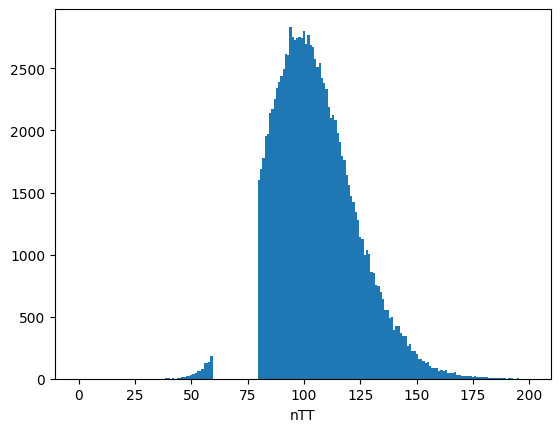

In [24]:
_=plt.hist(augmented_dataSet['l1tEmuNTT'],bins=np.arange(-0.5,200,1),density=False)
plt.xlabel('nTT')
plt.savefig(prefixBase+'/originalNTT_inArgumentedSet.png',bbox_inches='tight')
plt.show()
plt.close()

#### Obtaining the IsoEt as per the augumented nTT Distibution

The variation of mean IsoEt vs  NTT stays same even with the noise levels increasing. We can use this to estimate the nTT distribution for the events with augumented nTT 

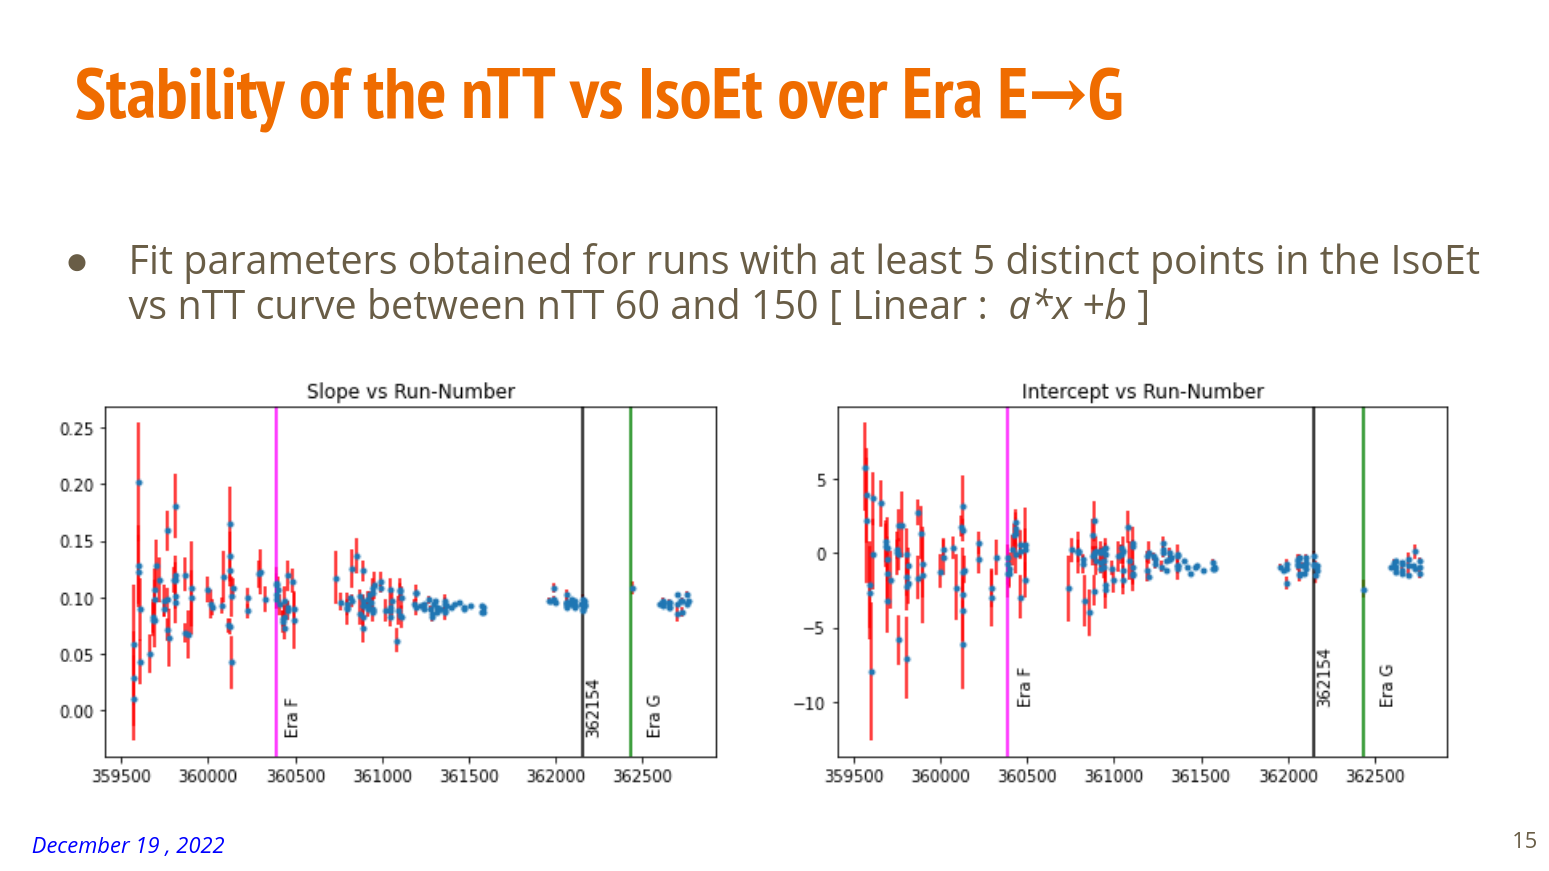


**The mean of the slope in era G is `0.0946`. We can offset the original IsoEt in the event using this slope and the difference of nTT in the event and the augumented_ntt**

In [39]:
dNTT =  augmented_nTTVals - augmented_dataSet['l1tEmuNTT']

In [40]:

augmented_isoEts = np.round( augmented_dataSet['l1tEmuIsoEt'] + dNTT* 0.0946)

In [41]:
augmented_dataSet['l1tEmuNTT']   = np.array(augmented_nTTVals, np.int32)
augmented_dataSet['l1tEmuIsoEt'] = np.array(augmented_isoEts, np.int32)

In [1]:
# _=plt.hist(dNTT,bins=np.arange(-200.5,200,1),density=False)
# plt.xlabel('nTT_orig - nTT_augmented')
# plt.savefig(prefixBase+'/dNTT_forArgumentedSet.png',bbox_inches='tight')
# plt.show()
# plt.close()

#### Merge the `augmented_dataSet` and `existingData`

In [43]:
final_dataset={ky : np.concatenate([existingData[ky],augmented_dataSet[ky]]) for ky in augmented_dataSet}

In [44]:
fd_mean=np.average(final_dataset['l1tEmuIsoEt'])
fd_rms= np.std(final_dataset['l1tEmuIsoEt'])
print(fd_mean,fd_rms)

ed_mean=np.average(existingData['l1tEmuIsoEt'])
ed_rms= np.std(existingData['l1tEmuIsoEt'])
print(ed_mean,ed_rms)

6.781272324177855 10.514620829852934
6.71947898702006 8.334314152611807


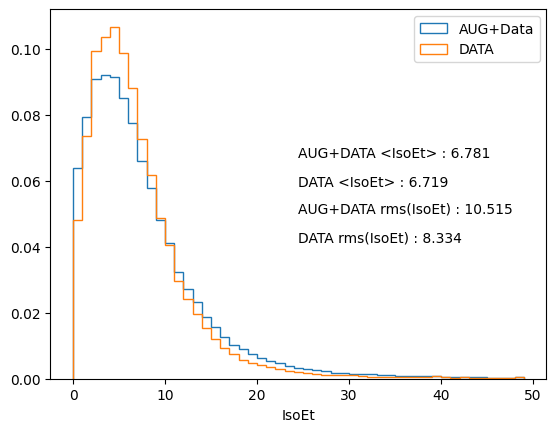

In [45]:
# _=plt.hist(augmented_isoEts,bins=np.arange(0.0,50.0,1),histtype='step'  , density=True , label ='AUG')
_=plt.hist(final_dataset['l1tEmuIsoEt'],bins=np.arange(0.0,50.0,1),histtype='step'  , density=True , label ='AUG+Data')
_=plt.hist(existingData['l1tEmuIsoEt'],bins=np.arange(0.0,50.0,1),histtype='step', density=True, label = 'DATA')
plt.xlabel('IsoEt')
plt.annotate('AUG+DATA <IsoEt> : '+str(np.round(fd_mean,3)),xy=(0.5,0.6),xycoords='axes fraction')
plt.annotate('DATA <IsoEt> : '+str(np.round(ed_mean,3)),xy=(0.5,0.52),xycoords='axes fraction')
plt.annotate('AUG+DATA rms(IsoEt) : '+str(np.round(fd_rms,3)),xy=(0.5,0.45),xycoords='axes fraction')
plt.annotate('DATA rms(IsoEt) : '+str(np.round(ed_rms,3)),xy=(0.5,0.37),xycoords='axes fraction')
plt.legend()

plt.savefig(prefixBase+'/isoEt_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

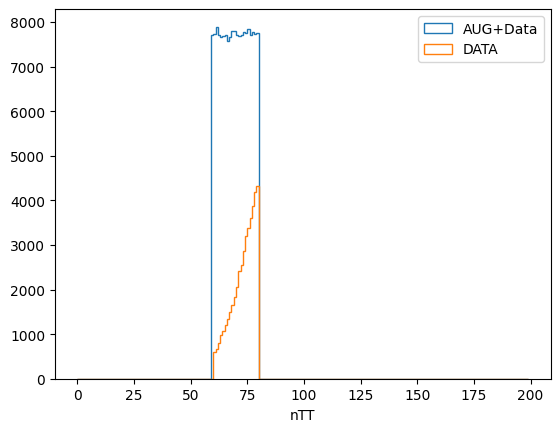

In [46]:
# _=plt.hist(augmented_dataSet['l1tEmuNTT'],bins=np.arange(0.0,200.0,1),histtype='step'  , density=True , label ='AUG')
_=plt.hist(final_dataset['l1tEmuNTT'],bins=np.arange(0.0,200.0,1),histtype='step'  , density=False , label ='AUG+Data')
_=plt.hist(existingData['l1tEmuNTT'],bins=np.arange(0.0,200.0,1),histtype='step', density=False, label = 'DATA')
plt.xlabel('nTT')
plt.legend()

plt.savefig(prefixBase+'/nTT_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

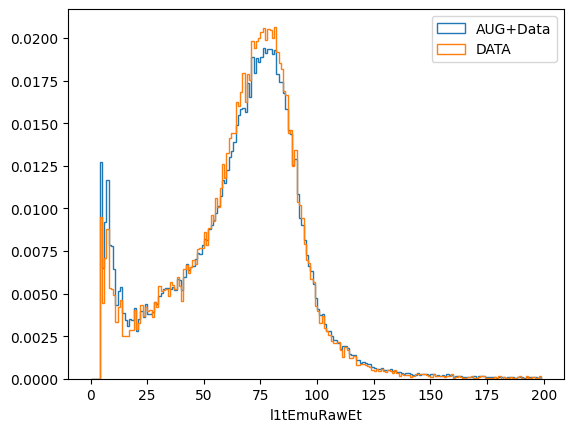

In [37]:
# _=plt.hist(augmented_dataSet['l1tEmuNTT'],bins=np.arange(0.0,200.0,1),histtype='step'  , density=True , label ='AUG')
_=plt.hist(final_dataset['l1tEmuRawEt'],bins=np.arange(0.0,200.0,1),histtype='step'  , density=True , label ='AUG+Data')
_=plt.hist(existingData['l1tEmuRawEt'],bins=np.arange(0.0,200.0,1),histtype='step', density=True, label = 'DATA')
plt.xlabel('l1tEmuRawEt')
plt.legend()

plt.savefig(prefixBase+'/rawEt_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

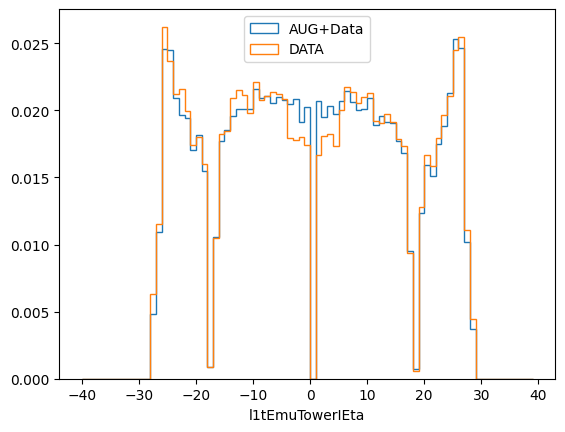

In [38]:
# _=plt.hist(augmented_dataSet['l1tEmuNTT'],bins=np.arange(0.0,200.0,1),histtype='step'  , density=True , label ='AUG')
_=plt.hist(final_dataset['l1tEmuTowerIEta'],bins=np.arange(-40.0,40.0,1),histtype='step'  , density=True , label ='AUG+Data')
_=plt.hist(existingData['l1tEmuTowerIEta'],bins=np.arange(-40.0,40.0,1),histtype='step', density=True, label = 'DATA')
plt.xlabel('l1tEmuTowerIEta')
plt.legend()

plt.savefig(prefixBase+'/towerEta_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

## Exporting the augmented dataset

In [149]:
file = urt.recreate("workarea/example.root")

In [150]:
for ky in baseSet:
    print(ky,baseSet[ky].dtype,final_dataset[ky].dtype)

l1tEmuNTT int32 int32
l1tEmuRawEt int32 int32
l1tEmuTowerIEta int32 int32
l1tEmuIsoEt int32 int32
eleProbeEta float32 float32
eleProbePhi float32 float32
eleTagEta float32 float32
eleTagPhi float32 float32
isProbeLoose int32 int32


In [151]:
allBranchesToWrite={ ky : final_dataset[ky].dtype for ky in final_dataset}

In [152]:
file.mktree("Ntuplizer/TagAndProbe",allBranchesToWrite)

<WritableTree '/Ntuplizer/TagAndProbe' at 0x7f037fbd2580>

In [153]:
file["Ntuplizer/TagAndProbe"].extend(final_dataset)

In [154]:
file.close()